In [2]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import time as time
import math, cmath
import sys
import auxiliary_library as me

from IPython.display import display, Math, Latex

In [17]:
basis = me.recursive_basis(N, 4, H_H, seed_op2)
mk_basis = [basis[a] + basis[a].dag() for a in range(len(basis))]
mk_basis = me.base_orth(basis, rho0)
mk_basis

[Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]],
 Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = False
 Qobj data =
 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]],
 Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = False
 Qobj data =
 [[ 0.01828946  0.          0.         ...  0.          0.00087093
    0.        ]
  [ 0.          0.01828946  0.         ...  0.          0.
    0.00087093]
  [ 0.          0.          0.01828946 ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ... -0.0165476   0.
    0.        ]
  

In [4]:
N = 5

spin_ops_list = me.one_body_spin_ops(N)
seed_op1 = Mz = sum(spin_ops_list[3][i] for i in range(N))
seed_op2 = Sx0Sx1 = spin_ops_list[1][0]*spin_ops_list[1][0+1] + spin_ops_list[1][1]*spin_ops_list[1][0] 

K = .5*seed_op2
rho0 = K.expm()
rho0 = rho0/rho0.tr()

chain_type = "XYZ"
Hamiltonian_paras = [.1, .15, .2, 1.]
H_H = me.Heisenberg_Hamiltonian(spin_ops_list, "XYZ", N, False, Hamiltonian_paras)

basis = me.recursive_basis(N, 4, H_H, seed_op2)
#mk_basis = [basis[a] + basis[a].dag() for a in range(len(basis))]
mk_basis = me.base_orth(basis, rho0)

# acÃ¡ un temita: 
# 1. yo me defino el estado inicial con algÃºn seed operator
# 2. pero despuÃ©s yo me cambio el seed operator cuando haga la ortonormalizaciÃ³n de GS

hij_tensor = me.H_ij_matrix(H_H, mk_basis, rho0)

# Operadores no hermÃ­ticos. Veo de hacerlos hermÃ­ticos la fuerza

In [5]:
from scipy.integrate import odeint

def F(y, t, HH):
    return HH.dot(y)

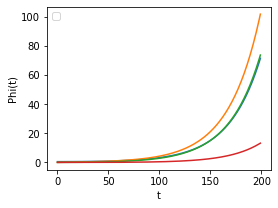

In [6]:
zero_list = [0 for i in range(len(mk_basis) - 1)]
Phi0_vec = [.5] + zero_list

ts=np.linspace(0,1,200)
result = odeint(func=F, y0=Phi0_vec,t=ts,args=(hij_tensor,))
plt.figure(figsize=(4, 3))

#for i in range(len(markov_basis)):
#    plt.plot(result[i], label=r'$\phi_{(%d)}(t)$'%i)

plt.plot(result)

plt.xlabel("t")
plt.ylabel("Phi(t)")
plt.legend()

In [7]:
rhos_at_timet = []

for i in range(len(result)):
    loc_rho = sum([result[i][a] * mk_basis[a] for a in range(len(mk_basis))])
    rhos_at_timet.append(loc_rho)
    loc_rho = 0

In [8]:
for i in range(len(rhos_at_timet)):
    #print(me.is_density_op(rhos_at_timet[i]))
    print(me.ev_checks(rhos_at_timet[i]))

Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
False
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
True
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues not positive
Eigenvalues no

In [9]:
def bures(rho, sigma):
    if me.is_density_op(rho) and is_density_op(sigma):
        val = abs((sqrtM(rho)*sqrtM(sigma)).tr())
        val = max(min(val,1.),-1.)
    return np.arccos(val)/np.pi

In [48]:
bures(rhos_at_timet[0], rhos_at_timet[100])

UnboundLocalError: local variable 'val' referenced before assignment

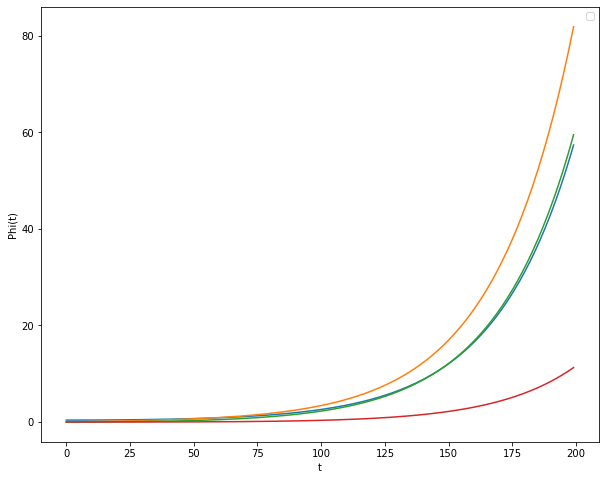

In [22]:
### VersiÃ³n vieja con errores


N = 5

spin_ops_list = me.one_body_spin_ops(N)
seed_op1 = Mz = sum(spin_ops_list[3][i] for i in range(N))
seed_op2 = Sx0Sx1 = spin_ops_list[1][0]*spin_ops_list[1][0+1] + spin_ops_list[1][1]*spin_ops_list[1][0] 

K = .4*seed_op2
rho0 = K.expm()
rho0 = rho0/rho0.tr()

chain_type = "XYZ"
Hamiltonian_paras = [.15, .15, .2, 1.]
H_H = me.Heisenberg_Hamiltonian(spin_ops_list, "XYZ", N, False, Hamiltonian_paras)

mk_basis = me.recursive_basis(N, 4, H_H, seed_op2)
mk_basis = me.base_orth(mk_basis, rho0)

hij_tensor = me.H_ij_matrix(H_H, mk_basis, rho0)

from scipy.integrate import odeint

def F(y, t, HH):
    return HH.dot(y)

zero_list = [0 for i in range(len(mk_basis)-1)]
Phi0_vec = [.4] + zero_list

ts=np.linspace(0,1,200)
result = odeint(func=F, y0=Phi0_vec,t=ts,args=(hij_tensor,))
plt.figure(figsize=(10, 8))

#for i in range(len(markov_basis)):
#    plt.plot(result[i], label=r'$\phi_{(%d)}(t)$'%i)

plt.plot(result)

plt.xlabel("t")
plt.ylabel("Phi(t)")
plt.legend()

In [124]:
basis = mk_basis
basis[0] == Sx0Sx1
basis[1] == me.commutator(H_H, Sx0Sx1)
basis[2] == me.commutator(H_H, me.commutator(H_H, Sx0Sx1))
basis[3] == me.commutator(H_H, me.commutator(H_H, me.commutator(H_H, Sx0Sx1)))
basis[4] == me.commutator(H_H, me.commutator(H_H, me.commutator(H_H, me.commutator(H_H, Sx0Sx1))))

True

In [84]:
N = 3

spin_ops_list = me.one_body_spin_ops(N)

Mz = sum(spin_ops_list[3][i] for i in range(N))
Sx0Sx1 = spin_ops_list[1][0]*spin_ops_list[1][0+1] + spin_ops_list[1][1]*spin_ops_list[1][0] 

K = .5*Mz + .5*Sx0Sx1
rho0 = K.expm()

chain_type = "XYZ"
Hamiltonian_paras = [.15, .15, .2, 1.]

#H_H, markov_basis = me.Hamiltonian_and_basis_obs(N, spin_ops_list, chain_type, Hamiltonian_paras, True)

H_H = me.Heisenberg_Hamiltonian(spin_ops_list, "XYZ", N, False, Hamiltonian_paras)

markov_basis = [Mz, Sx0Sx1]
markov_basis = me.base_orth(markov_basis, rho0)

t0_weights, rho0 = me.initial_conditions(markov_basis)
hij_tensor = me.H_ij_matrix(H_H, markov_basis, rho0)
hij_tensor

array([[ 0.00000000e+00,  0.00000000e+00],
       [-1.04083409e-17,  3.25260652e-19]])

In [50]:
N = 4
chain_type = "XXZ"

#sx_list = me.one_body_spin_ops(N)[1]
#sz_list = me.one_body_spin_ops(N)[3]

big_list = me.one_body_spin_ops(N)
Hamiltonian_paras = [.15, .15, .2, 1.]

H_H, markov_basis = me.Hamiltonian_and_basis_obs(N, big_list, chain_type, Hamiltonian_paras, True)
t0_weights, rho0 = me.initial_conditions(markov_basis)
hij_tensor = me.H_ij_matrix(H_H, markov_basis, rho0)

#y0 = np.array([np.random.rand() for i in hij_tensor])
ts=np.linspace(0,100,100)

In [51]:
from scipy.integrate import odeint

def F(y, t, HH):
    return HH.dot(y)

result = odeint(func=F, y0=t0_weights,t=ts,args=(hij_tensor,))

In [62]:
result[:,0]

array([0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624577,
       0.35624577, 0.35624577, 0.35624577, 0.35624577, 0.35624

In [ ]:
<O>(t)

d/dt <O> = <[H,O]>
d/dt <[H,O]> = <[H, [H,O]]>
d/dt <[H,[H,O]]> = <[H, [H,[H,O]]>


# https://stackoverflow.com/questions/52317000/how-to-reshape-a-2d-numpy-array-or-qobj-into-dims-2-2-2-2


In [28]:
loc_globalid = qutip.tensor([qutip.qeye(2) for k in range(5)])
loc_globalid

Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = True
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]

Two-body Gaussian initial state chosen
two-body operator chosen
Closed evolution chosen
type rho=<class 'qutip.qobj.Qobj'>
sampling: 30
type rho= <class 'qutip.qobj.Qobj'>
--- 55.482916831970215 seconds ---
Two-body Gaussian initial state chosen
two-body operator chosen
Closed evolution chosen
type rho=<class 'qutip.qobj.Qobj'>
sampling: 30
type rho= <class 'qutip.qobj.Qobj'>
--- 89.15258479118347 seconds ---


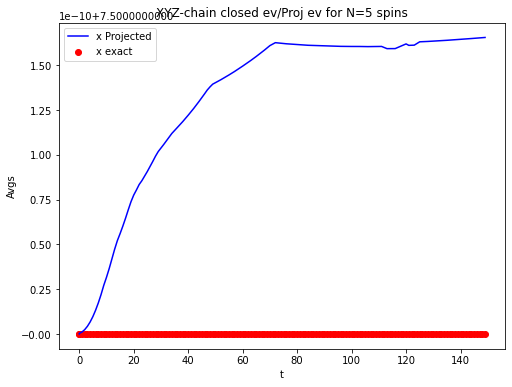

In [11]:
start_time = time.time()
unitary_ev = True; gamma = None
size = N; gaussian = True; gr = 2; xng = .7
chain_type = "XYZ"

resultsA, title = me.spin_chain_ev(size = size, init_state = rho0, chain_type = chain_type, Hamiltonian_paras = Hamiltonian_paras, 
                                omega_1=3., omega_2=3., temp=1, tmax = 150, deltat = 1, 
                                two_body_basis = True, unitary_ev = unitary_ev, gamma = gamma,
                                gaussian = gaussian, gr = gr, xng = xng, do_project = True)

print("--- %s seconds ---" % (time.time() - start_time))

resultsB, title = me.spin_chain_ev(size = size, init_state = rho0, chain_type = chain_type, Hamiltonian_paras = Hamiltonian_paras, 
                                omega_1=3., omega_2=3., temp=1, tmax = 150, deltat = 1,  
                                two_body_basis = True, unitary_ev = unitary_ev, gamma = gamma,
                                gaussian = gaussian, gr = gr, xng = xng, do_project = False)

print("--- %s seconds ---" % (time.time() - start_time))

plt.figure(figsize=(8, 6))
plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected", color = "blue")
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact", color = "red")

plt.xlabel("t")
plt.ylabel("Avgs")

plt.title(title)
plt.legend()

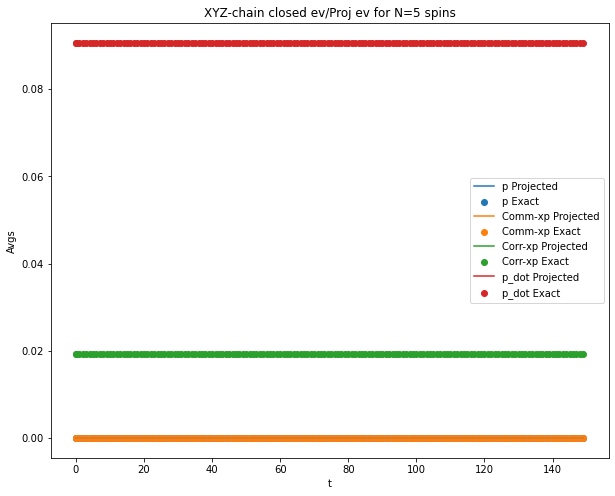

In [12]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()